In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
%matplotlib inline

In [9]:
import os
import pickle
from glob import glob

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

#from scipy.optimize import lsq_linear
#from sklearn.linear_model import LinearRegression

matplotlib.rcParams.update({'font.size': 18, 'figure.facecolor':'white', 'figure.figsize':(8, 8)})

%cd /home/naodell/work/hgcal/ECONAutoencoderStudy

/home/naodell/work/hgcal/ECONAutoencoderStudy


In [10]:
# get the data
input_file = open('data/output_0.pkl', 'rb')
data_dict = pickle.load(input_file)
df_tc = data_dict['tc']
df_gen = data_dict['gen']
df_clusters = data_dict['Threshold0']


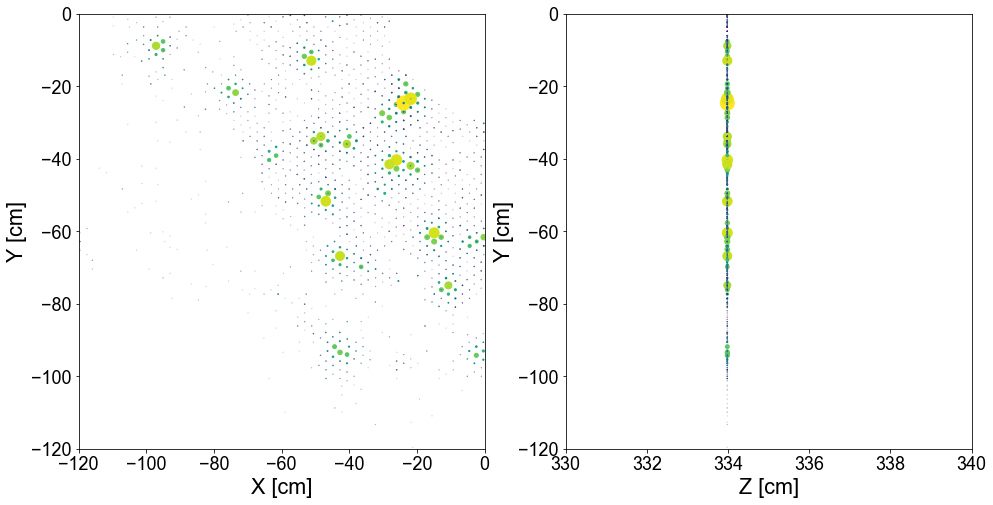

In [11]:
# make some basic plots
fig, axes = plt.subplots(1, 2, facecolor='white', figsize=(16, 8))

cuts = 'tc_z > 0 and tc_x < 0. and tc_y < 0. and tc_subdet == 1 and tc_layer == 9'
event_ix = df_tc.index[0][0]
event_tc = df_tc.query(cuts)
event_cluster = df_clusters.loc[event_ix]
event_gen = df_gen.loc[event_ix]

ax = axes[0]
ax.scatter(event_tc.tc_x, event_tc.tc_y, s=event_tc.tc_energy, c=np.log(event_tc.tc_energy))
ax.set_xlim(-120, 0)
ax.set_ylim(-120, 0)
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')


#x, y = np.linspace(-100, 100, 50), np.linspace(-100, 100, 50)
#X, Y = np.mgrid[-100:100:5, -100:100:5]
#ax.scatter(X, Y, marker='h', s=70, alpha=0.5)

ax = axes[1]
ax.scatter(event_tc.tc_z, event_tc.tc_y, s=event_tc.tc_energy, c=np.log(event_tc.tc_energy))
ax.set_xlim(330, 340)
ax.set_ylim(-120, 0)
ax.set_xlabel('Z [cm]')
ax.set_ylabel('Y [cm]')

plt.show()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, cursive


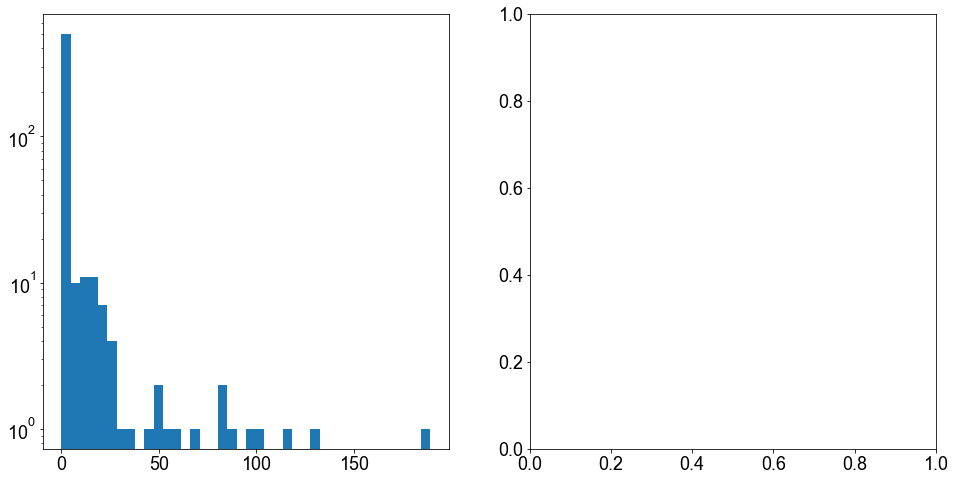

In [12]:
# make some basic plots
fig, axes = plt.subplots(1, 2, facecolor='white', figsize=(16, 8))

ax = axes[0]
ax.hist(event_tc.query('tc_simenergy > 0.1').tc_simenergy, bins=40)
ax.set_yscale('log')
#ax.set_xlim(320, 365)

ax = axes[1]
#ax.hist(

plt.show()

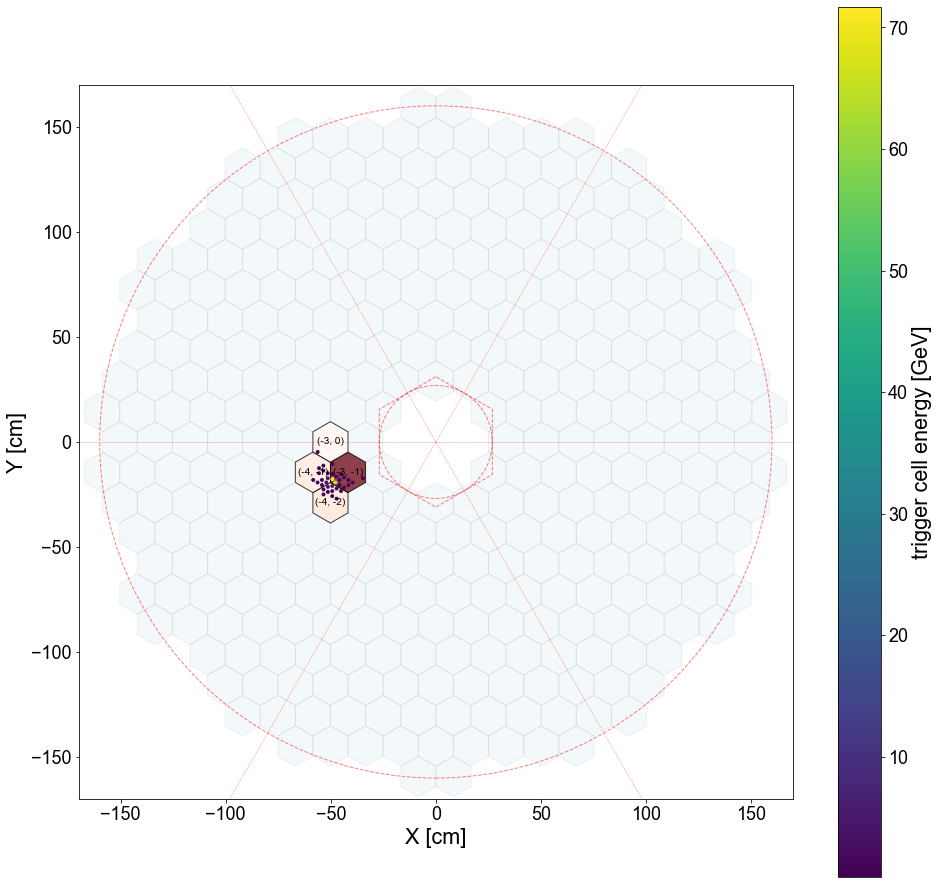

In [18]:
from matplotlib.patches import RegularPolygon, Circle
from itertools import product
cmap = matplotlib.cm.get_cmap('Reds')


#cuts = 'tc_z > 0 and tc_x < 0. and tc_y < 0. and tc_subdet == 1 and tc_layer == 9'
cuts = 'tc_z < 0 and tc_subdet == 1 and tc_layer == 11 and tc_energy > 0.1'
df_tc['count'] = 1
df_cut = df_tc.query(cuts)
events = df_cut.index.get_level_values(0).unique()
event_ix = events[10]
event_tc = df_cut.loc[event_ix]
#event_cluster = df_clusters.loc[event_ix]
#event_gen = df_gen.loc[event_ix]

group_wafer = event_tc.groupby(['tc_waferu', 'tc_waferv'])
wafer_sums = group_wafer.sum()

# draw each module 
u = np.arange(-13, 14)
coord = np.array(list(product(u, u)))
#coord = [(0, 0), (0, 1), (1, 0), (0, -1), (-1, 0), (0, 1), (1, 1), (-1, -1), (0, -1)]

# Horizontal cartesian coords
angle = np.pi/6
hex_radius = 0.95*8*2.54/2
d = 2*hex_radius*np.cos(angle)
#trans_matrix = np.array([[1., np.sin(angle)], [0., np.sin(np.pi/2 - angle)]])
xcoord = [d*(c[0] - c[1]*np.sin(angle)) for c in coord]
ycoord = [d*c[1]*np.sin(np.pi/2 - angle) for c in coord]

fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_aspect('equal')

# draw hexegonal grid
inner_radius = 0.82*32.8
outer_radius = 160
energy_max = wafer_sums['tc_energy'].max()
for x, y, u, v in zip(xcoord, ycoord, coord.T[0], coord.T[1]):
    #color = c[0].lower()  # matplotlib understands lower case words for colours
    r = np.sqrt(x**2 + y**2)
    if r < inner_radius or r > outer_radius:
        continue
        
    if (u, v) in wafer_sums.index:
        color = cmap(wafer_sums.loc[(u, v), 'tc_energy']/energy_max)
        alpha = 0.75
    else:
        color = 'C0'
        alpha = 0.05
        
    poly = RegularPolygon((x, y), 
                         numVertices=6, 
                         radius=hex_radius, 
                         orientation=np.radians(0), 
                         facecolor=color, 
                         alpha=alpha, 
                         edgecolor='k',
                         zorder=1
                        )
    ax.add_patch(poly)
    
    # Add text labels
    if color != 'C0':
        ax.text(x, y+0.2, f'({u}, {v})', ha='center', va='center', size=10)
    
# inner hexagon
inner_circle = Circle((0, 0), 
                     radius=inner_radius,
                     facecolor='none', 
                     alpha=0.5, 
                     linestyle='--',
                     edgecolor='r'
                     )
ax.add_patch(inner_circle)

poly = RegularPolygon((0, 0), 
                     numVertices=6, 
                     radius=inner_radius/np.cos(angle), 
                     orientation=np.radians(0), 
                     facecolor='none', 
                     alpha=0.5, 
                     linestyle='--',
                     edgecolor='r'
                    )
ax.add_patch(poly)

# outer hexagon
outer_circle = Circle((0, 0), 
                     radius=160, 
                     facecolor='none', 
                     alpha=0.5, 
                     linestyle='--',
                     edgecolor='r'
                     )
ax.add_patch(outer_circle)

poly = RegularPolygon((0, 0), 
                     numVertices=6, 
                     radius=160, 
                     orientation=np.radians(30), 
                     facecolor='none', 
                     alpha=0.5, 
                     edgecolor='r'
                    )

# draw lines every pi/3 radians
for angle in np.arange(0, 360, 60):
    rad = (angle/180)*np.pi
    plt.plot([0., 200*np.cos(rad)], [0., 200*np.sin(rad)], 'r--', linewidth=0.5, alpha=0.5)
              
#ax.add_patch(poly)
marker_size = 100. / (1 + np.exp(-event_tc.tc_energy/10))
scat = ax.scatter(event_tc.tc_x, event_tc.tc_y, 
                  marker='H', 
                  s=10, #marker_size, 
                  c=event_tc.tc_energy,
                  zorder=2
                 )
#ax.set_xlim(-80, -20)
#ax.set_ylim(-50, 20)
ax.set_xlim(-170, 170)
ax.set_ylim(-170, 170)
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')

cbar = plt.colorbar(scat)
cbar.set_label('trigger cell energy [GeV]')

plt.show()